# Project Goal

The goal of this notebook is to explore the world of SMS spam filters.

This includes:
- getting the data
- exploring the data
- generating features
- testing the performance of several classification algorithms

# Getting the Data

The dataset we will be using is available from http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/.
It has a total of 4,827 legitimate (ham) SMS messages (86.6%) and a total of 747 (13.4%) spam messages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re

%matplotlib notebook

# loading the data from a text file
data = pd.read_table('SMSSpamCollectionData', names=["label", "message"])

# relabelling 'ham' (non-spam) as 0, and 'spam' as 1
data.label[data.label == 'ham'] = 0
data.label[data.label == 'spam'] = 1
data.label = data.label.apply(pd.to_numeric)

data.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Data Exploration

In [2]:
# match all characters other then alphanumerics, whitespace, '.', or ','
specialcharspattern = re.compile(r'[^\w\s.,]')

# Generate new features
data['char_length'] = [len(i) for i in data.message]
data['word_length'] = [len(i.split()) for i in data.message]
data['avg_char_per_word'] = data['char_length']/data['word_length']
data['special_chars'] = [len(specialcharspattern.findall(i)) for i in data.message]
data['percentage_special_chars'] = data['special_chars']/data['char_length']
data.head()

,label,message,char_length,word_length,avg_char_per_word,special_chars,percentage_special_chars
0,0,"Go until jurong point, crazy.. Available only ...",111,20,5.550000,0,0.000000
1,0,Ok lar... Joking wif u oni...,29,6,4.833333,0,0.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,5.535714,5,0.032258
3,0,U dun say so early hor... U c already then say...,49,11,4.454545,0,0.000000
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,4.692308,1,0.016393


In [3]:
# %%timeit
# initialize arrays for new features
# def new_feature(dtype=np.object):
#     return np.zeros(data.index.shape, dtype=dtype)
#
# charlengths = new_feature(np.int32)
# wordlengths = new_feature(np.int32)
# specialchars = new_feature(np.int32)
#
# for i, message in enumerate(data.message):
#     charlengths[i] = len(message)
#     wordlengths[i] = len(message.split())
#     specialchars[i] = len(specialcharspattern.findall(message))

Summary statistics of the ham messages:

In [4]:
data[data.label == 0].describe()

,label,char_length,word_length,avg_char_per_word,special_chars,percentage_special_chars
count,4825.0,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.0,71.482487,14.310259,5.060947,1.637720,0.024431
std,0.0,58.440652,11.517945,1.104705,2.859433,0.036840
min,0.0,2.000000,1.000000,2.000000,0.000000,0.000000
25%,0.0,33.000000,7.000000,4.500000,0.000000,0.000000
50%,0.0,52.000000,11.000000,4.925926,1.000000,0.014706
75%,0.0,93.000000,19.000000,5.428571,2.000000,0.035714
max,0.0,910.000000,171.000000,49.000000,92.000000,0.857143


Summary statistics of the spam messages:

In [5]:
data[data.label == 1].describe()

,label,char_length,word_length,avg_char_per_word,special_chars,percentage_special_chars
count,747.0,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.0,138.670683,23.911647,5.922567,3.503347,0.025201
std,0.0,28.873603,5.780174,0.984617,2.701092,0.019161
min,1.0,13.000000,2.000000,4.250000,0.000000,0.000000
25%,1.0,133.000000,22.000000,5.366667,2.000000,0.012739
50%,1.0,149.000000,25.000000,5.814815,3.000000,0.021739
75%,1.0,157.000000,28.000000,6.304348,5.000000,0.034602
max,1.0,223.000000,35.000000,18.166667,22.000000,0.153285


<IPython.core.display.Javascript object>


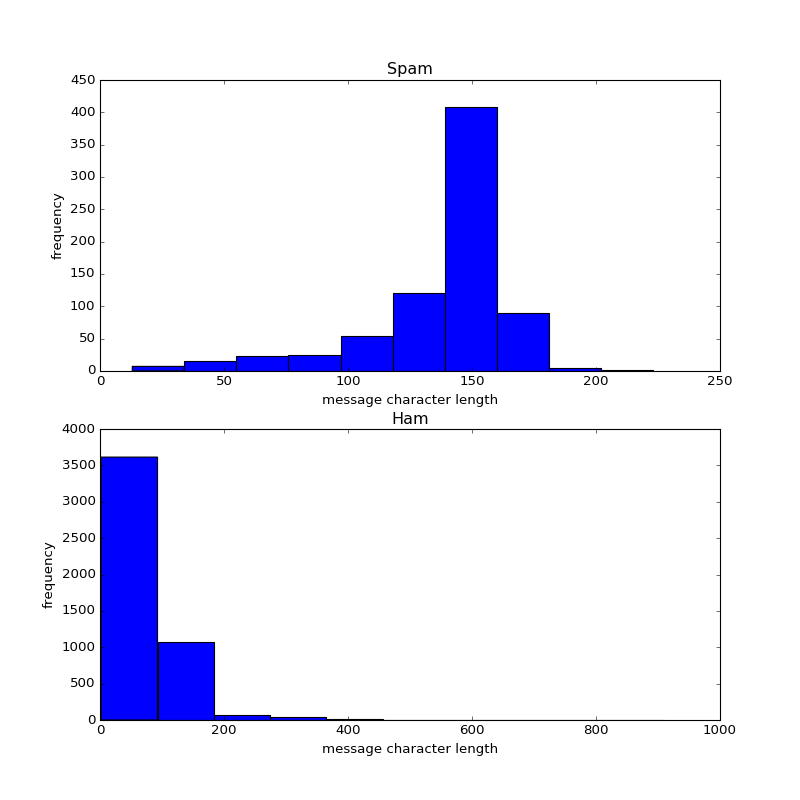

138.670682731
71.4824870466


In [15]:
spam_index = data.label[data.label == 1].index
ham_index = data.label[data.label == 0].index

fig, axes = plt.subplots(2,1,figsize=(10,10))
axes[0].hist(data.char_length[spam_index])
axes[0].set_title('Spam')
axes[0].set_ylabel('frequency')
axes[0].set_xlabel('message character length')
axes[1].hist(data.char_length[ham_index])
axes[1].set_title('Ham')
axes[1].set_ylabel('frequency')
axes[1].set_xlabel('message character length')
plt.show()

<IPython.core.display.Javascript object>


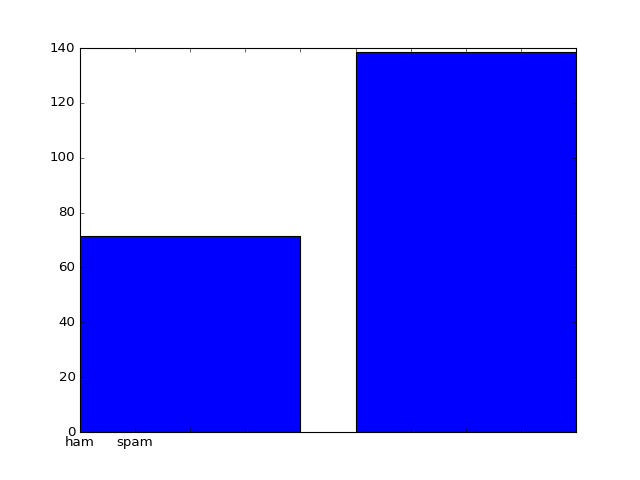

In [7]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(2), (np.mean(data.char_length[ham_index].values),
                               np.mean(data.char_length[spam_index].values)))


ax.set_xticklabels(('ham', 'spam'))

# Feature Engineering

# Implementing a Naive Bayes Classifier

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# 80/20 random train/test split 
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.2)

y_train
print(type(y_train))
print(y_train.dtype)

print(len(y_train[y_train==1])/len(y_train[y_train==0]))
print(len(y_test[y_test==1])/len(y_test[y_test==0]))

<class 'pandas.core.series.Series'>
int64
0.15526179367547951
0.15305067218200621


In [9]:
# CountVectorizer extracts words from the SMS messages and creates
# a sparse matrix representation of the counts of the words in each message
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)

X_test_counts = count_vect.transform(X_test)
accuracy = classifier.score(X_test_counts, y_test)

predictions = classifier.predict(X_test_counts)
CM = confusion_matrix(y_test, predictions)

print(classification_report(y_test, predictions))
print('Total Accuracy: {}'.format(accuracy))
print(CM)

classifier.feature_count_

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       967
          1       0.98      0.90      0.94       148

avg / total       0.98      0.98      0.98      1115

Total Accuracy: 0.9838565022421525
[[964   3]
 [ 15 133]]


array([[  0.,   0.,   0., ...,   0.,   1.,   1.],
       [  9.,  23.,   2., ...,   1.,   0.,   0.]])

In [10]:
classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)


count_vect??




# Reducing False Positives